In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ptlpinns.odes import numerical, equations
from scipy.interpolate import CubicSpline
import torch

## Equation parameters

In [219]:
alpha = 0.2
x0, y0 = 1.1, 0.99
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], 5120)

## Lotka-Volterra RK45 solution

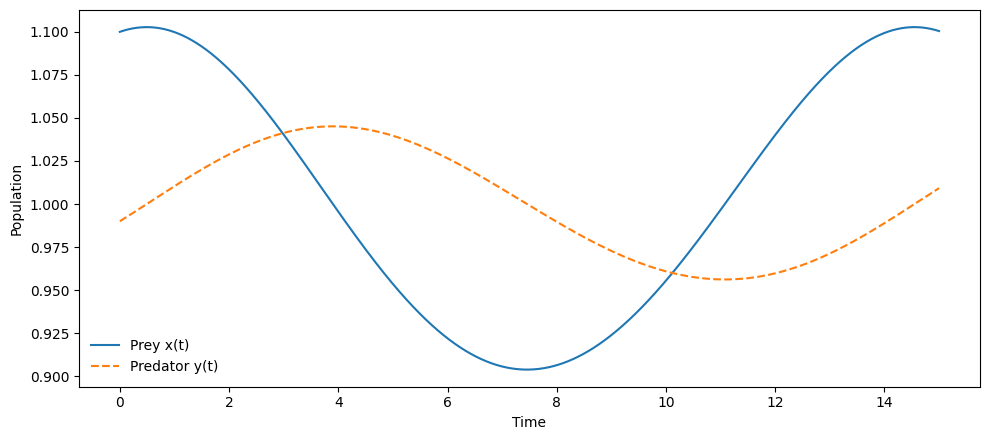

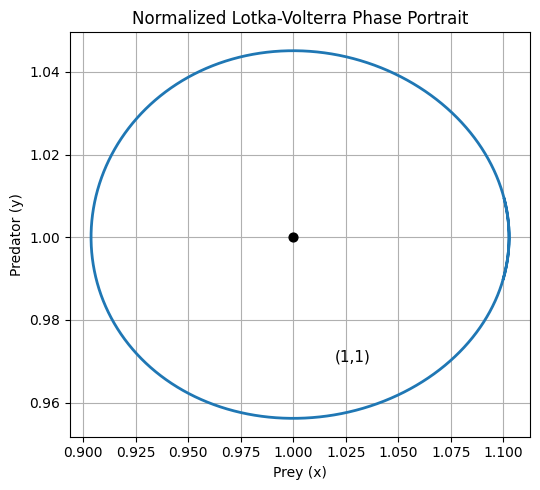

In [220]:
ode = equations.lv_normalized(alpha)

sol = numerical.solve_ode_equation(ode, t_span, t_eval, [x0, y0])
x, y = sol  # unpack solution components

plt.figure(figsize=(10, 4.5))
plt.plot(t_eval, x, label="Prey x(t)")
plt.plot(t_eval, y, '--', label="Predator y(t)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend(frameon=False)
plt.tight_layout()

plt.figure(figsize=(5.5, 5.0))
plt.plot(x, y, lw=2)
plt.scatter([1], [1], s=40, zorder=5, color="k")
plt.text(1.02, 0.97, "(1,1)", fontsize=11)
plt.xlabel("Prey (x)")
plt.ylabel("Predator (y)")
plt.title("Normalized Lotka-Volterra Phase Portrait")
plt.grid(True)
plt.tight_layout()
plt.show()


## Perturbation solution


In [221]:
epsilon = 0.1
xi0 = (x0 - 1) / epsilon
eta0 = (y0 - 1) / epsilon
w_0 = np.sqrt(alpha)

### 0th-order solution

In [222]:
def lv_0th_order(alpha):

    def lv(t, z):
        x, y = z
        dx = - y
        dy = alpha * x
        return [dx / np.sqrt(alpha), dy / np.sqrt(alpha)]

    return lv

correction_0 = numerical.solve_ode_equation(lv_0th_order(alpha), t_span, t_eval, [xi0, eta0])
xi_0, eta_0 = correction_0

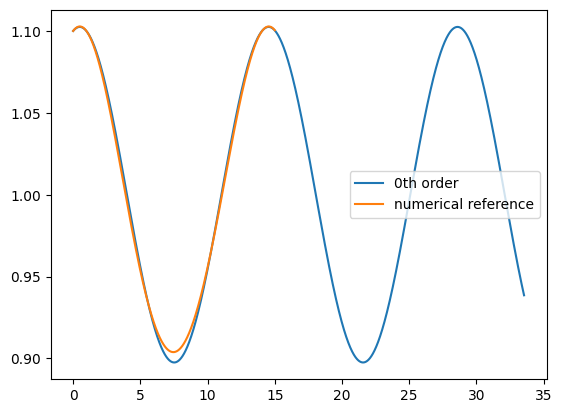

In [223]:
# don't forget xi_0 is defined in tau!
plt.plot(t_eval / np.sqrt(alpha), 1 + epsilon * xi_0, label="0th order")
plt.plot(t_eval, x, label="numerical reference")
plt.legend()

### LKV Functions

In [224]:
def xi_x_eta(eta, xi, N):

    result = np.zeros_like(xi[0])
    for i in range(N):
        result += xi[i] * eta[N - 1 - i]

    return result

def dtau_xi_w(xi_dot, w_list, N):

    result = np.zeros_like(xi_dot[0])
    for i in range(1, N):
        result += w_list[i] * xi_dot[N - i]

    return result

def calc_B(eta, xi, xi_dot, w_list, N):
    
    return dtau_xi_w(xi_dot, w_list, N) + xi_x_eta(eta, xi, N)

def calculate_forcing_xi(w_n, w_list, eta, xi, xi_dot):

    B_term = calc_B(eta, xi, xi_dot, w_list, N=len(xi))
    w_n_term = w_n * xi_dot[0]

    return - w_n_term - B_term

def calculate_forcing_eta(w_n, w_list, eta, xi, eta_dot):

    N = len(eta)
    B_term = dtau_xi_w(eta_dot, w_list, N) + alpha * xi_x_eta(eta, xi, N)
    w_n_term = w_n * eta_dot[0]

    return - w_n_term + B_term

In [225]:
def calc_w_n(w_list, xi, xi_dot, eta, t_eval):

    lib = np if type(xi[0]) == np.ndarray else torch

    mask    = (t_eval >= 0) & (t_eval <= 2*lib.pi)
    t_seg   = t_eval[mask]    

    xi_seg = [term[mask] for term in xi]
    eta_seg = [term[mask] for term in eta] 
    xi_dot_seg = [term[mask] for term in xi_dot] 

    N = len(xi)
    B = calc_B(eta_seg, xi_seg, xi_dot_seg, w_list, N)
    K = - xi_dot_seg[0]

    num = lib.trapezoid(B * (eta_seg[0]), x=t_seg)
    den = lib.trapezoid(K * (eta_seg[0]), x=t_seg)

    w_n = num / den

    return w_n

### Solving higher-orders

calculating term p: 1
omega 1: -4.816093791674389e-06


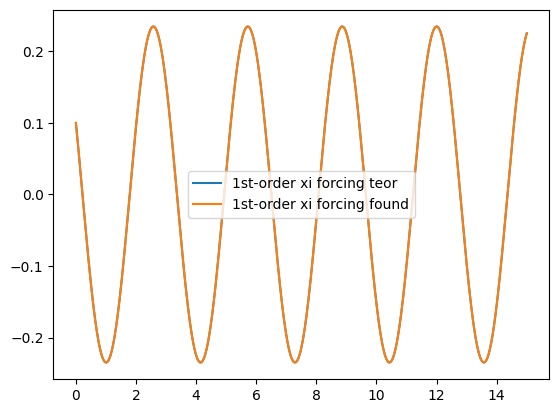

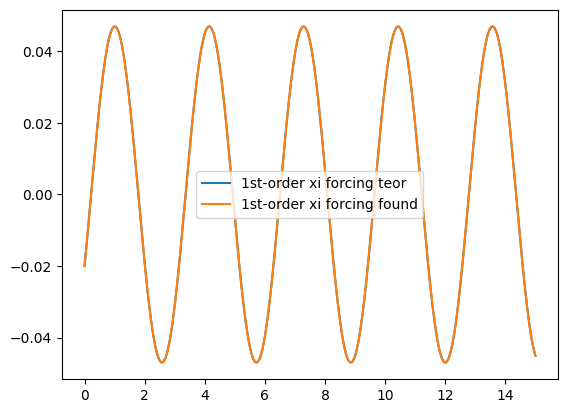

calculating term p: 2
omega 2: -0.039129674924069394
calculating term p: 3
omega 3: 0.03870136421271386
calculating term p: 4
omega 4: -0.02994619908215304
calculating term p: 5
omega 5: 0.01769478545243594
calculating term p: 6
omega 6: -0.008031085329547653
calculating term p: 7
omega 7: 0.0037420098909683387
calculating term p: 8
omega 8: -0.004209882832729839
calculating term p: 9
omega 9: 0.006552535489130036
calculating term p: 10
omega 10: -0.007787780432824957


In [226]:
n_corrections = 10
w_list, xi_list, eta_list = [w_0], [xi_0], [eta_0]
xi_dot, eta_dot = [np.gradient(xi_0, t_eval)], [np.gradient(eta_0, t_eval)]

for p in range(1, n_corrections + 1):

    print(f"calculating term p: {p}")
    w_n = calc_w_n(w_list, xi_list, xi_dot, eta_list, t_eval)
    print(f"omega {p}: {w_n}")

    xi_forcing = calculate_forcing_xi(w_n, w_list, eta_list, xi_list, xi_dot)
    xi_forcing_interp = CubicSpline(t_eval, xi_forcing)

    eta_forcing = calculate_forcing_eta(w_n, w_list, eta_list, xi_list, eta_dot)
    eta_forcing_interp = CubicSpline(t_eval, eta_forcing)

    def lv_nth_order(t, z):
        x, y = z
        dx = - y + xi_forcing_interp(t)
        dy = alpha * x + eta_forcing_interp(t)
        return np.array([dx / np.sqrt(alpha), dy / np.sqrt(alpha)])

    # solving x_n ode
    xi_nth_order, eta_nth_order = (numerical.solve_ode_equation(lv_nth_order, t_span, t_eval, np.array([0,0])))  

    w_list.append(w_n)
    xi_list.append(xi_nth_order)
    eta_list.append(eta_nth_order)
    xi_dot.append(np.gradient(xi_nth_order, t_eval))
    eta_dot.append(np.gradient(eta_nth_order, t_eval))

    
    if p == 1:
        plt.plot(t_eval, (- xi_list[0] * eta_list[0] - w_list[1] * xi_dot[0]), label = "1st-order xi forcing teor")
        plt.plot(t_eval, xi_forcing_interp(t_eval), label = "1st-order xi forcing found")
        plt.legend()
        plt.show()

        plt.plot(t_eval, alpha * xi_list[0] * eta_list[0] - w_list[1] * eta_dot[0], label = "1st-order xi forcing teor")
        plt.plot(t_eval, eta_forcing_interp(t_eval), label = "1st-order xi forcing found")
        plt.legend()
        plt.show()

    #if p == 2:
    #    plt.plot(t_eval, (- xi_list[0] * eta_list[0] - w_list[1] * xi_dot[0]), label = "2nd-order xi forcing teor")
    #    plt.plot(t_eval, xi_forcing_interp(t_eval), label = "2nd-order xi forcing found")
    #    plt.legend()





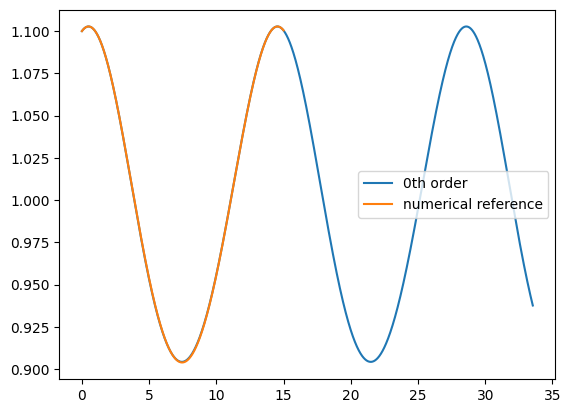

In [227]:
# don't forget xi_0 is defined in tau!
plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1]), 1 + epsilon * xi_0 + epsilon ** 2 * xi_list[1], label="0th order")
plt.plot(t_eval, x, label="numerical reference")
plt.legend()

In [228]:
# w_2 expected value
A = xi_0.max()
- (A ** 2 * np.sqrt(alpha))/24 - (A ** 2 * alpha * np.sqrt(alpha))/24

np.float64(-0.023478712642586677)

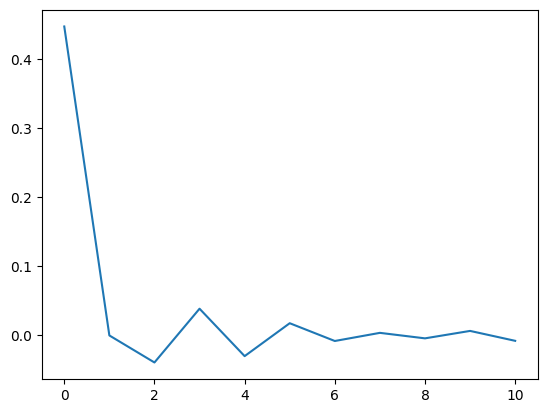

In [229]:
# plot series convergence instead
plt.plot(np.arange(len(w_list)), w_list)